In [1]:
#Below loads all the preliminaries for the analysis.
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import simplefilter

#statistical modelling
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#ML and Forecasting
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError,
    mean_absolute_percentage_error,
)
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

In [ ]:
"""
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')
"""
#pd.set_option('display.max_rows', None)

In [2]:
data = pd.read_csv(r'D:\Documents\tesla.csv', index_col=0, parse_dates=['Date'])
data.sort_values(by='Date', ascending='True')


,Close/Last,Volume,Open,High,Low
Date,,,,,
2016-06-09,45.87,22271110,$46.996,$47.066,$45.412
2016-06-10,43.76,29972740,$45.478,$45.594,$43.6843
2016-06-13,43.57,20939165,$43.9,$45.154,$43.532
2016-06-14,42.99,17879110,$43.776,$44.44,$42.506
2016-06-15,43.54,14525010,$43.39,$44.38,$43.026
...,...,...,...,...,...
2021-06-02,605.12,23302780,$620.13,$623.36,$599.14
2021-06-03,572.84,30111890,$601.8,$604.55,$571.22
2021-06-04,599.05,24036900,$579.71,$600.61,$577.2


In [3]:
ts = data
ts = ts.sort_index()
#ts.index = ts.index.to_period(freq='M')
ts = ts.asfreq('D')
ts = ts.fillna(method='ffill')

In [4]:
ts = ts['Close/Last']

In [5]:
ts.describe()

count    1826.000000
mean      160.475559
std       209.354173
min        35.790000
25%        51.962500
50%        65.030000
75%       130.170000
max       883.090000
Name: Close/Last, dtype: float64

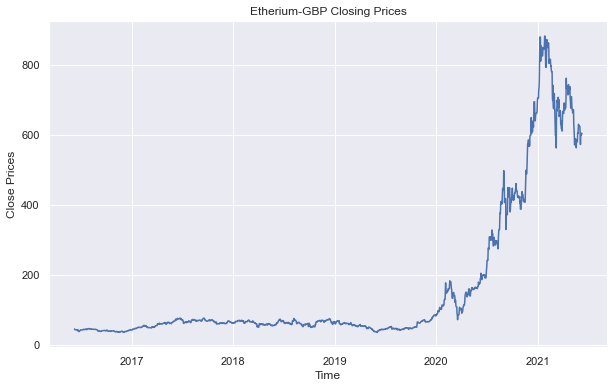

In [6]:
#line graph of closing price, shows seasonality/trend 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Close Prices')
plt.plot(ts)
plt.title('Etherium-GBP Closing Prices')
plt.show()


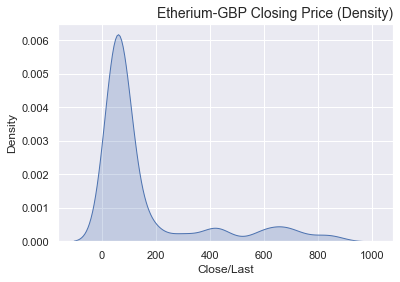

In [7]:
#Density shows positive skewness 
sns.set_style('darkgrid')
sns.kdeplot(ts, shade=True)
plt.title('Etherium-GBP Closing Price (Density)', loc = 'right', fontsize=14)

plt.show()

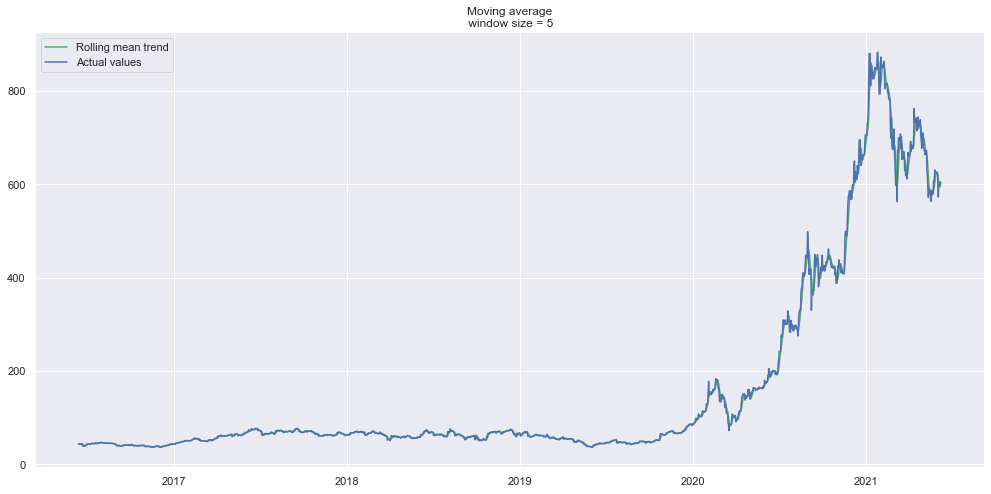

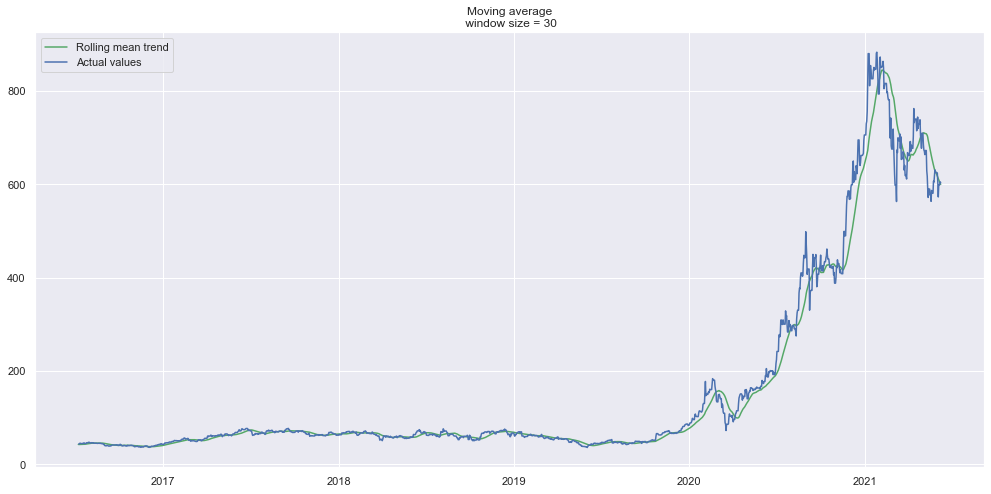

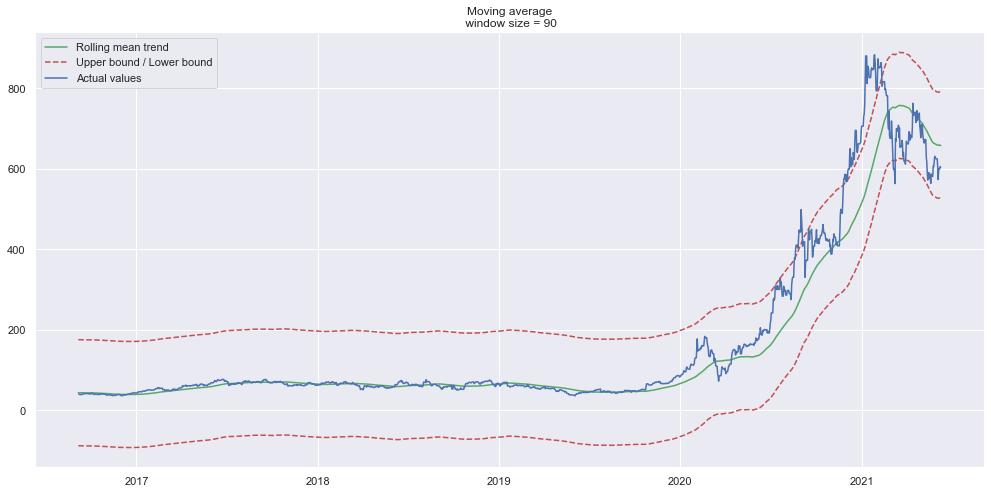

In [8]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(ts, 5)

#Smooth by the previous month (30 days)
plot_moving_average(ts, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(ts, 90, plot_intervals=True)

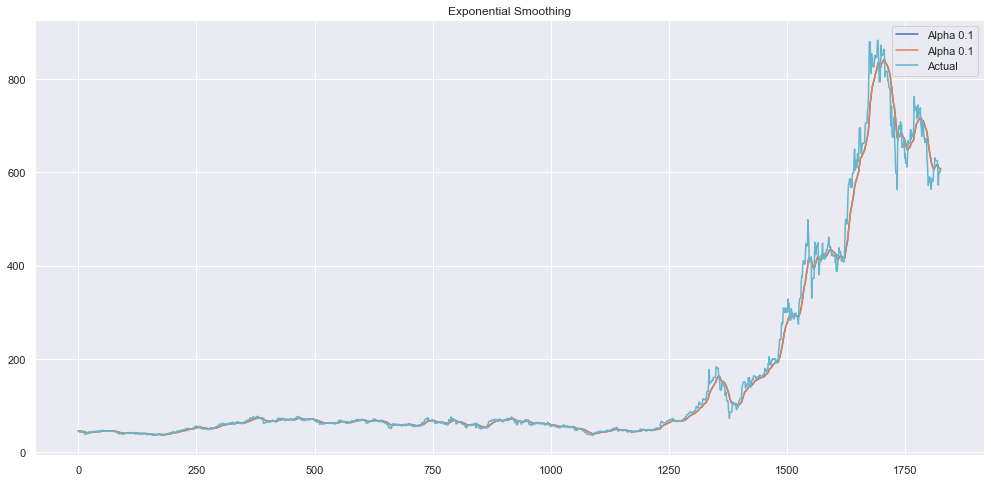

In [9]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(ts, [0.1, 0.1])

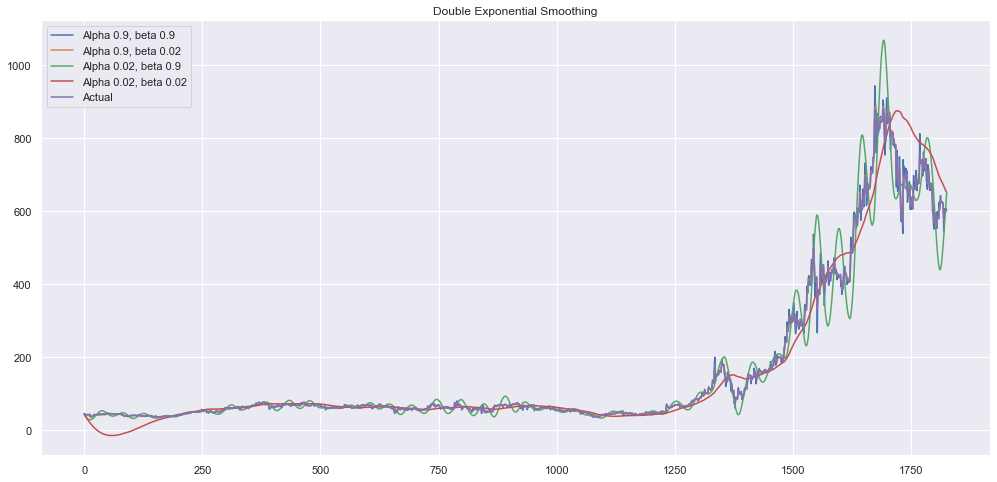

In [10]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(ts, alphas=[0.9, 0.02], betas=[0.9, 0.02])

C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


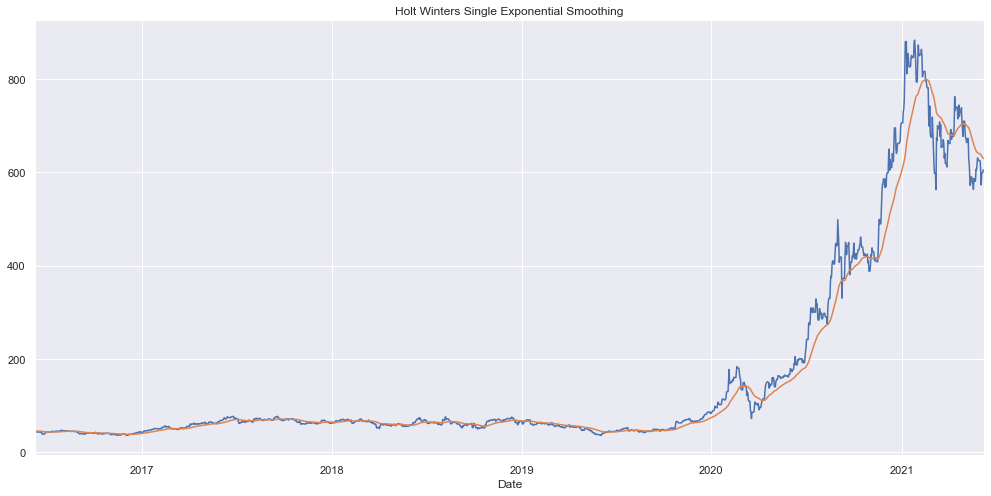

In [20]:
m = 12
alpha = 1/(2*m)

ts_expadd = SimpleExpSmoothing(ts).fit(smoothing_level=alpha ,optimized=False,use_brute=True).fittedvalues
plt.figure(figsize=(17, 8))
ts.plot(title='Holt Winters Single Exponential Smoothing')
ts_expadd.plot(title='Holt Winters Single Exponential Smoothing')
plt.show()

In [ ]:
#Dickey-Fuller TEST


def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(ts, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = ts - ts.shift(1)

tsplot(data_diff[1:], lags=30)

In [ ]:
data_diff = data_diff.dropna()

In [ ]:

# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

---------------------------------------------------

In [ ]:
mod = sm.tsa.statespace.SARIMAX(data_diff,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
# Import the library
from pmdarima import auto_arima
  
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
  
# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(data_diff, start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 65,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  